# Import Library & Load File

In [1]:
import re, string
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud, STOPWORDS

from keras.preprocessing import text
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation

import keras
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, Dropout
from tensorflow.keras.preprocessing.sequence import pad_sequences
import tensorflow as tf

In [2]:
# Menghubungkan notebook dengan Google Drive

from google.colab import drive
drive.mount('/content/drive/', force_remount = True)

Mounted at /content/drive/


In [3]:
true = pd.read_csv('/content/drive/My Drive/Colab Notebooks/True.csv')
false = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Fake.csv')

In [4]:
true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [5]:
false.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
true['category'] = 1
false['category'] = 0

In [7]:
df = pd.concat([true,false])

In [8]:
df.head()

,title,text,subject,date,category
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017",1
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017",1
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017",1
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017",1
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017",1


# Explore Dataset

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 44898 entries, 0 to 23480
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   title     44898 non-null  object
 1   text      44898 non-null  object
 2   subject   44898 non-null  object
 3   date      44898 non-null  object
 4   category  44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 2.1+ MB


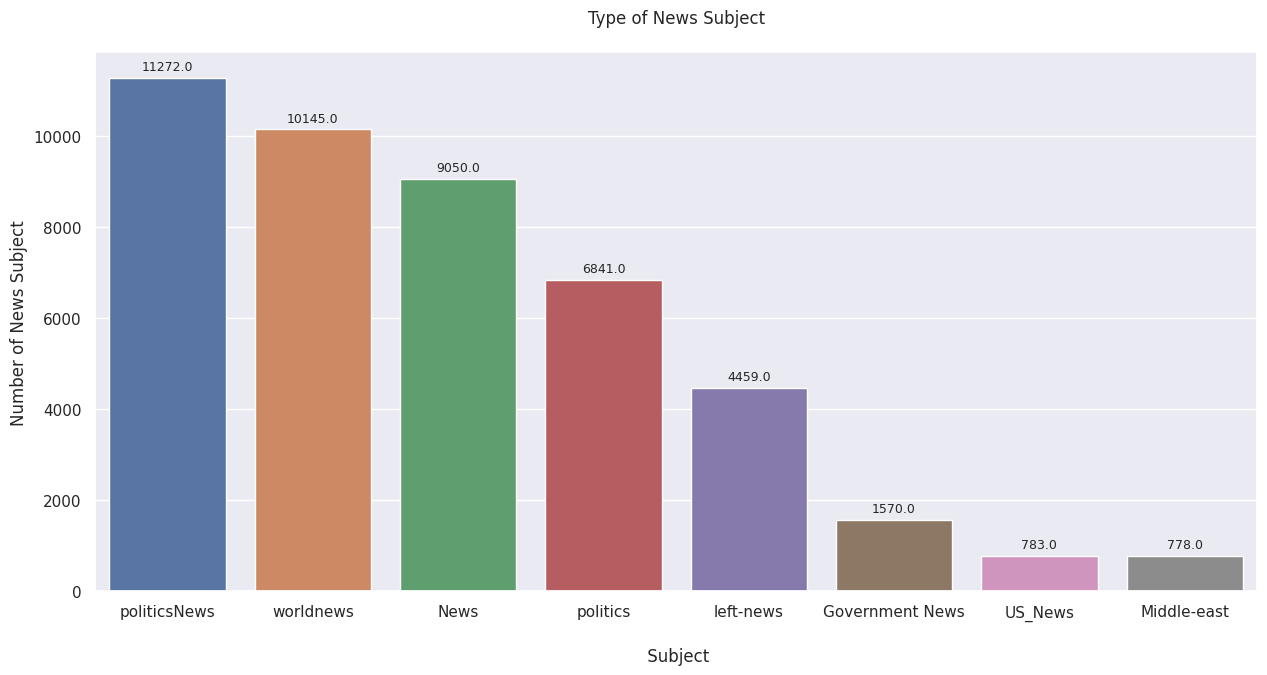

In [10]:
# Eksplor banyaknya data dari masing masing subjek artikel

type_df = df['subject'].value_counts().sort_values(ascending=False).head(10)
type_df = pd.DataFrame(type_df)
type_df = type_df.reset_index()

# Plotting
sns.set()
plt.figure(figsize=(15, 7))
type_plt = sns.barplot(x='index', y='subject', data=type_df)

for bar in type_plt.patches:
  type_plt.annotate(format(bar.get_height()),
                   (bar.get_x() + bar.get_width() / 2,
                    bar.get_height()), ha='center', va='center',
                   size=9, xytext=(0, 8),
                   textcoords='offset points')

plt.xlabel("\n Subject")
plt.ylabel("Number of News Subject")
plt.title("Type of News Subject\n")
plt.show()

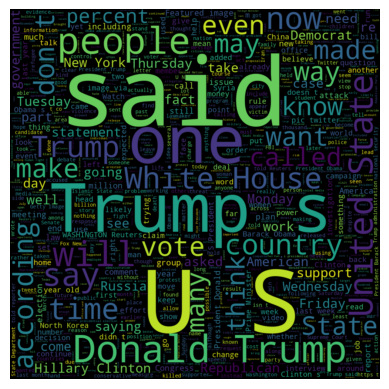

In [11]:
# Eksplor kata yang sering muncul dari seluruh dataset dengan word cloud

wc = WordCloud(background_color="black", max_words=1000,
               max_font_size=256,
               random_state=123, width=1000, height=1000)
wc.generate(' '.join(map(str, df['text'])))
plt.imshow(wc, interpolation="bilinear")
plt.axis('off')
plt.show()

Text(0, 0.5, 'Count of News Articles')

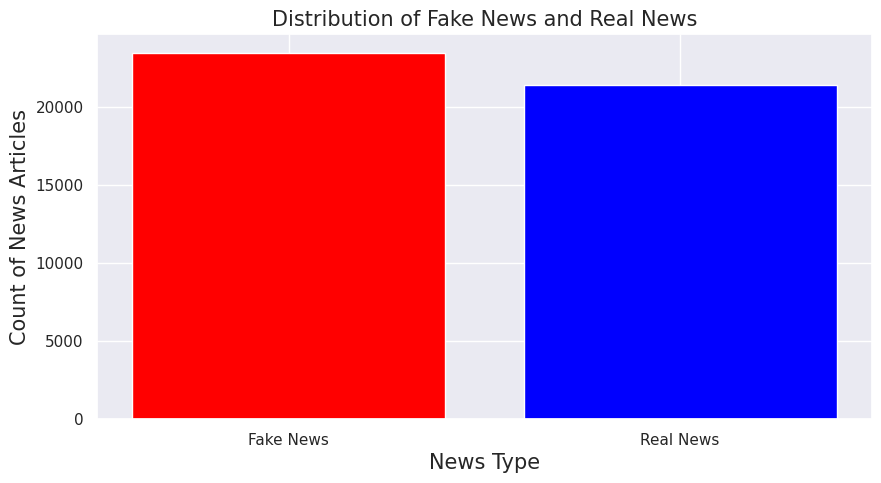

In [12]:
plt.figure(figsize=(10, 5))
plt.bar('Fake News', len(false), color='red')
plt.bar('Real News', len(true), color='blue')
plt.title('Distribution of Fake News and Real News', size=15)
plt.xlabel('News Type', size=15)
plt.ylabel('Count of News Articles', size=15)

In [13]:
df.isna().sum()

title       0
text        0
subject     0
date        0
category    0
dtype: int64

# Data Cleaning and Preparation

## Menggabungkan semua data teks ke dalam satu kolom

In [14]:
df['text'] = df['text'] + " " + df['title']
df = df.drop(columns=['title', 'subject', 'date'])

In [15]:
df.tail()

,text,category
23476,21st Century Wire says As 21WIRE reported earl...,0
23477,21st Century Wire says It s a familiar theme. ...,0
23478,Patrick Henningsen 21st Century WireRemember ...,0
23479,21st Century Wire says Al Jazeera America will...,0
23480,21st Century Wire says As 21WIRE predicted in ...,0


In [16]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
# Mengambil stopwords dalam bahasa inggris

stop = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stop.update(punctuation)

In [18]:
# Remove stopwords from text
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stop:
            final_text.append(i.strip())
    return " ".join(final_text)

# Remove noisy text
def clean_text(text):
    text = text.lower()
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('\\W', ' ', text)
    text = re.sub('\n', '', text)
    text = re.sub(' +', ' ', text)
    text = re.sub('^ ', '', text)
    text = re.sub(' $', '', text)
    text = remove_stopwords(text)
    return text

# Get cleaned text
df['text'] = df['text'].apply(clean_text)

# Train Test Split

In [19]:
# Membagi data latih dan data uji dengan proposisi 70:30

X = df['text'].values
y = df['category'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 123)

In [20]:
max_features = 10000
maxlen = 300

In [21]:
# Tokenizing setiap kata dalam teks dan mapping pada data latih

tokenizer = text.Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(X_train)

sequence_train = tokenizer.texts_to_sequences(X_train)
sequence_test = tokenizer.texts_to_sequences(X_test)

padded_train = pad_sequences(sequence_train, maxlen=maxlen)
padded_test = pad_sequences(sequence_test, maxlen=maxlen)

In [22]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=max_features, output_dim=128),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(16)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer=keras.optimizers.Adam(lr = 0.01), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 128)         1280000   
                                                                 
 bidirectional (Bidirectiona  (None, None, 128)        98816     
 l)                                                              
                                                                 
 bidirectional_1 (Bidirectio  (None, 32)               18560     
 nal)                                                            
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 3

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [23]:
history = model.fit(padded_train,
                    y_train,
                    batch_size=128,
                    epochs=10,
                    steps_per_epoch=80,
                    validation_data=(padded_test, y_test),
                    verbose='auto')

Epoch 1/10
80/80 [==============================] - 247s 3s/step - loss: 0.1677 - accuracy: 0.9380 - val_loss: 0.0709 - val_accuracy: 0.9764
Epoch 2/10
80/80 [==============================] - 234s 3s/step - loss: 0.0631 - accuracy: 0.9813 - val_loss: 0.0561 - val_accuracy: 0.9820
Epoch 3/10
80/80 [==============================] - 240s 3s/step - loss: 0.0609 - accuracy: 0.9826 - val_loss: 0.0422 - val_accuracy: 0.9869
Epoch 4/10
80/80 [==============================] - 238s 3s/step - loss: 0.0212 - accuracy: 0.9934 - val_loss: 0.0737 - val_accuracy: 0.9809
Epoch 5/10
80/80 [==============================] - 238s 3s/step - loss: 0.0202 - accuracy: 0.9939 - val_loss: 0.0480 - val_accuracy: 0.9895
Epoch 6/10
80/80 [==============================] - 212s 3s/step - loss: 0.0224 - accuracy: 0.9940 - val_loss: 0.0522 - val_accuracy: 0.9852
Epoch 7/10
80/80 [==============================] - 233s 3s/step - loss: 0.0108 - accuracy: 0.9971 - val_loss: 0.0671 - val_accuracy: 0.9869
Epoch 8/10
80

In [24]:
model.evaluate(padded_test, y_test)

421/421 [==============================] - 74s 177ms/step - loss: 0.0700 - accuracy: 0.9848


[0.06996052712202072, 0.9847809672355652]

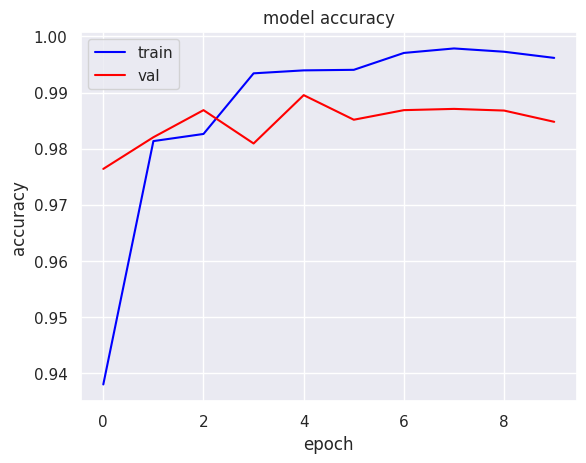

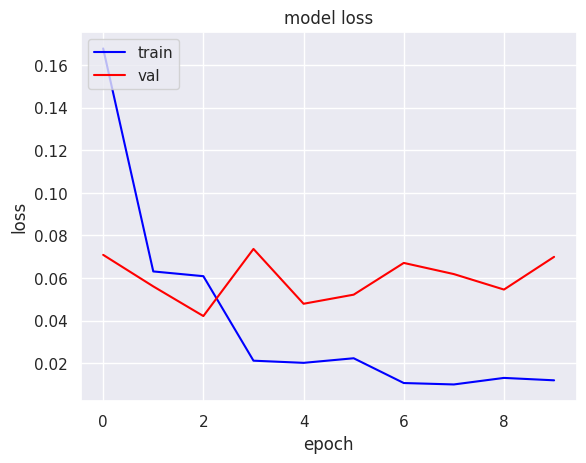

In [25]:
# Menampilkan grafik log model

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.plot(acc, color='blue')
plt.plot(val_acc, color='red')
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

plt.plot(loss, color='blue')
plt.plot(val_loss, color='red')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [26]:
pred = model.predict(padded_test)

421/421 [==============================] - 76s 177ms/step


In [27]:
y_pred = np.where(pred > 0.5, 1, 0)

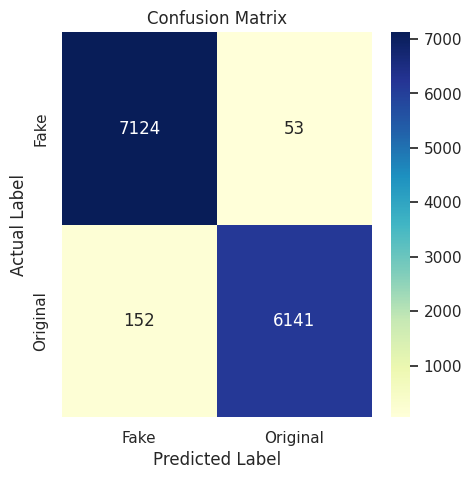

In [28]:
# Confusion Matrix

cm = confusion_matrix(y_test, y_pred)
plt.subplots(figsize=(5, 5))
sns.heatmap(pd.DataFrame(cm), annot=True, cmap="YlGnBu",
            fmt='g', yticklabels=['Fake', 'Original'],
            xticklabels = ['Fake','Original'])
plt.title('Confusion Matrix')
plt.ylabel('Actual Label')
plt.xlabel('Predicted Label')
plt.show()